# Position Reconstruction for XeBRA - Centroids - Measurements Analysis

**Status:** August 2019

Position reconstruction for XeBRA using centroids.

In [1]:
## Imports:

import sys
import glob

import numpy as np
from numpy import exp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline

import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

import pandas as pd
import math

from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import griddata
from scipy.stats import chisquare
from scipy.stats import power_divergence

## General Definitions and Parameters

In [2]:
#### General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties

R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

,PMT_ID,PMT_position_x,PMT_position_y,PMT_position_R,PMT_position_Phi
1,1,-14.0,-28.0,31.304952,-2.034444
2,2,-28.0,0.0,28.000000,3.141593
3,3,-14.0,28.0,31.304952,2.034444
4,4,14.0,28.0,31.304952,1.107149
5,5,28.0,0.0,28.000000,0.000000
6,6,14.0,-28.0,31.304952,-1.107149
7,7,0.0,0.0,0.000000,0.000000


## Imports and Data Processing

In [4]:
!ls /home/ab602/Thesis/Xebra_Measurements_Analysis/S2_Area_Fraction/output/*.pkl
!ls /home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/*.pkl

ls: cannot access '/home/ab602/Thesis/Xebra_Measurements_Analysis/S2_Area_Fraction/output/*.pkl': No such file or directory
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00157_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00158_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00159_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00161_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00162_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00163_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00186_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_00187_Kr83m_S2_AF.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/

In [5]:
#### Import processed measurements data

## Define run to be used
## Good Kr83m runs concerning S2 AF: 00157, 00158, (00159,) 00163; best so far: 00158
run = "00158"

## Import pandas dataframe from pkl
try:
    df_meas = pd.read_pickle("/home/ab602/Thesis/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_"+run+"_Kr83m_S2_AF.pkl")
except:
    pass
try:
    df_meas = pd.read_pickle("/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_Area_Fraction/output/run_"+run+"_Kr83m_S2_AF.pkl")
except:
    print('Selected file cannot be found.')
    
filenameprefix = "run_"+run+"_Kr83m_S2_AF"
print(filenameprefix)
df_meas

run_00158_Kr83m_S2_AF


,PMT1,PMT2,PMT3,PMT4,PMT5,PMT6,PMT7
area,"[81.51187, 58.73296, 505.49127, 329.77402, 336...","[54.27654, 81.40954, 1438.9236, 235.8328, 1276...","[155.54578, 162.00565, 153.64876, 153.18832, 2...","[964.6338, 1214.074, 85.29809, 130.35835, 91.2...","[560.59515, 852.8486, 126.01928, 334.0981, 113...","[105.141235, 94.01074, 172.28401, 482.03452, 1...","[473.47507, 275.31464, 595.08093, 1736.5447, 5..."
HF,"[0.03403163464572272, 0.021447941888815488, 0....","[0.022660740204117076, 0.029728912922178632, 0...","[0.06494117905931028, 0.05916077941069192, 0.0...","[0.40273967628852736, 0.4433522194041271, 0.02...","[0.23405142276139163, 0.3114409130092604, 0.04...","[0.04389701829874486, 0.03433058616553222, 0.0...","[0.19767832874218608, 0.1005386471993942, 0.19..."
hist_HF_bins_center,"[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000..."
hist_HF_n,"[0.0, 0.0849843310139693, 10.091889307908854, ...","[0.0, 0.11472884686885855, 10.559303128485686,...","[0.0, 0.8370956604875976, 19.308440006373825, ...","[0.0, 0.22095926063632018, 19.6526265469804, 1...","[0.0, 0.012747649652095395, 0.7053699474159452...","[0.0, 0.004249216550698465, 0.7266160301694375...","[0.0, 0.0, 0.0, 0.0042492165506984635, 0.02974..."


In [6]:
HF_list = np.array([df_meas['PMT1']['HF'], 
          df_meas['PMT2']['HF'], df_meas['PMT3']['HF'], 
          df_meas['PMT4']['HF'], df_meas['PMT5']['HF'], 
          df_meas['PMT6']['HF'], df_meas['PMT7']['HF']])
HF_list = HF_list.T # IMPORTANT!!!
HF_list.shape       # (n, 7)

(18827, 7)

## Reconstruction

In [7]:
x_list = np.array([np.sum(HF_list[i]*PMT_position_x) for i in range(0, HF_list.shape[0])])
y_list = np.array([np.sum(HF_list[i]*PMT_position_y) for i in range(0, HF_list.shape[0])])

In [8]:
## Save reconstructed positions in pandas dataframe

d = {'x_pos': x_list, 'y_pos': y_list}
Reconstruction_Centroid = pd.DataFrame(data=d)
Reconstruction_Centroid.to_pickle(filenameprefix+"_Reconstruction_Centroid.pkl")
Reconstruction_Centroid

,x_pos,y_pos
0,10.786233,10.913062
1,13.446973,12.508565
2,-13.775311,-3.993569
3,1.341471,-4.348050
4,-13.210608,-1.859828
5,-15.541644,-3.536831
6,17.252015,-7.880570
7,-2.473916,-2.051890
8,3.023582,19.449927
9,-6.059033,-0.142149


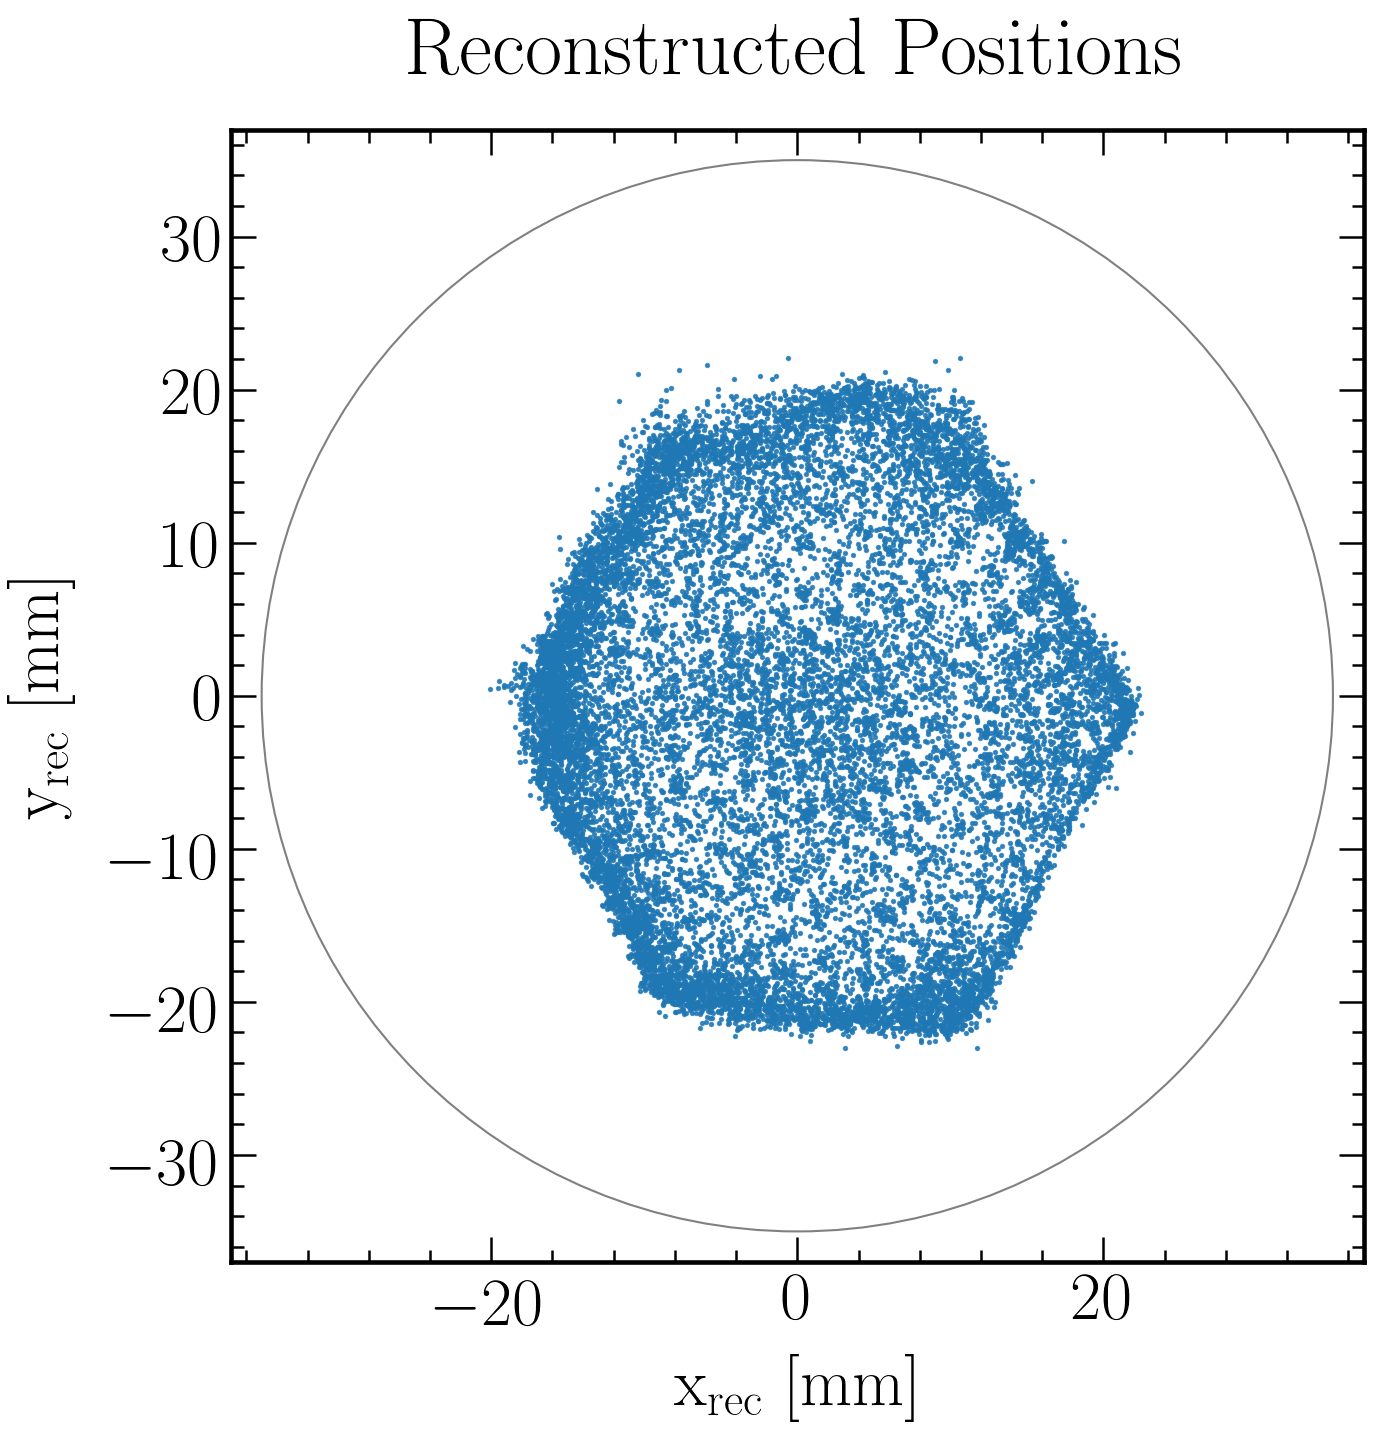

In [9]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(x_list,
            y_list,
            marker='.',
            #s=1,
            s = 10,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid.png", bbox_inches = "tight")

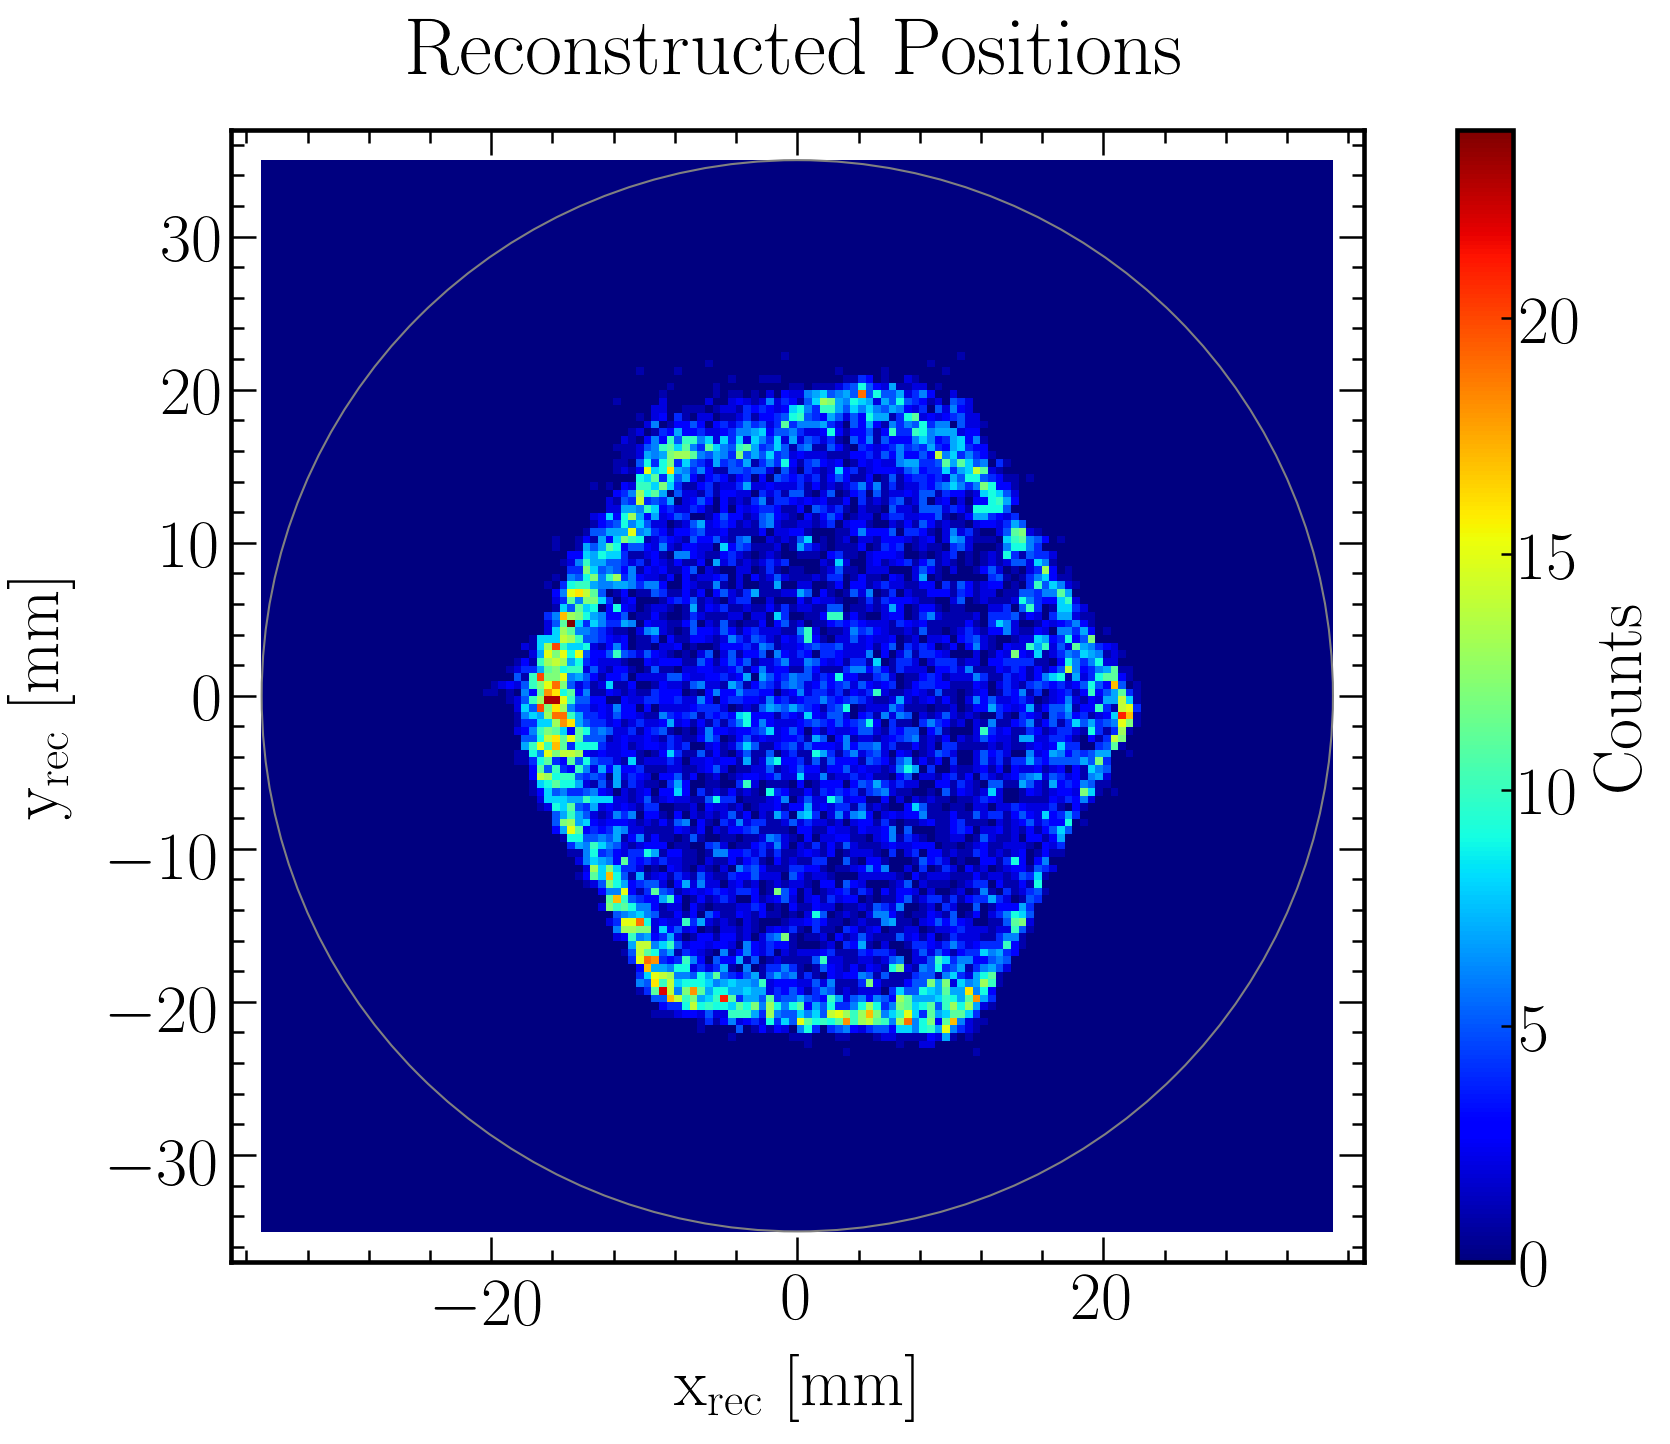

In [10]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
numberbins = 2*70
x = x_list
y = y_list

plt.hist2d(x, y, bins=numberbins, range = [[-35, 35], [-35, 35]], cmap = 'jet')

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Counts', fontsize=label_size)

r_fiducial = 20 # fiducial radius in mm
cut_fiducial = np.hypot(x_list, y_list)<r_fiducial
n, xedges, yedges = np.histogram2d(x[cut_fiducial], y[cut_fiducial], bins=numberbins, range = [[-35, 35], [-35, 35]])
#plt.clim(0.0, np.amax(n))
#plt.clim(0.0, np.percentile(n[n>0], 99))

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid_cmap.png", bbox_inches = "tight")

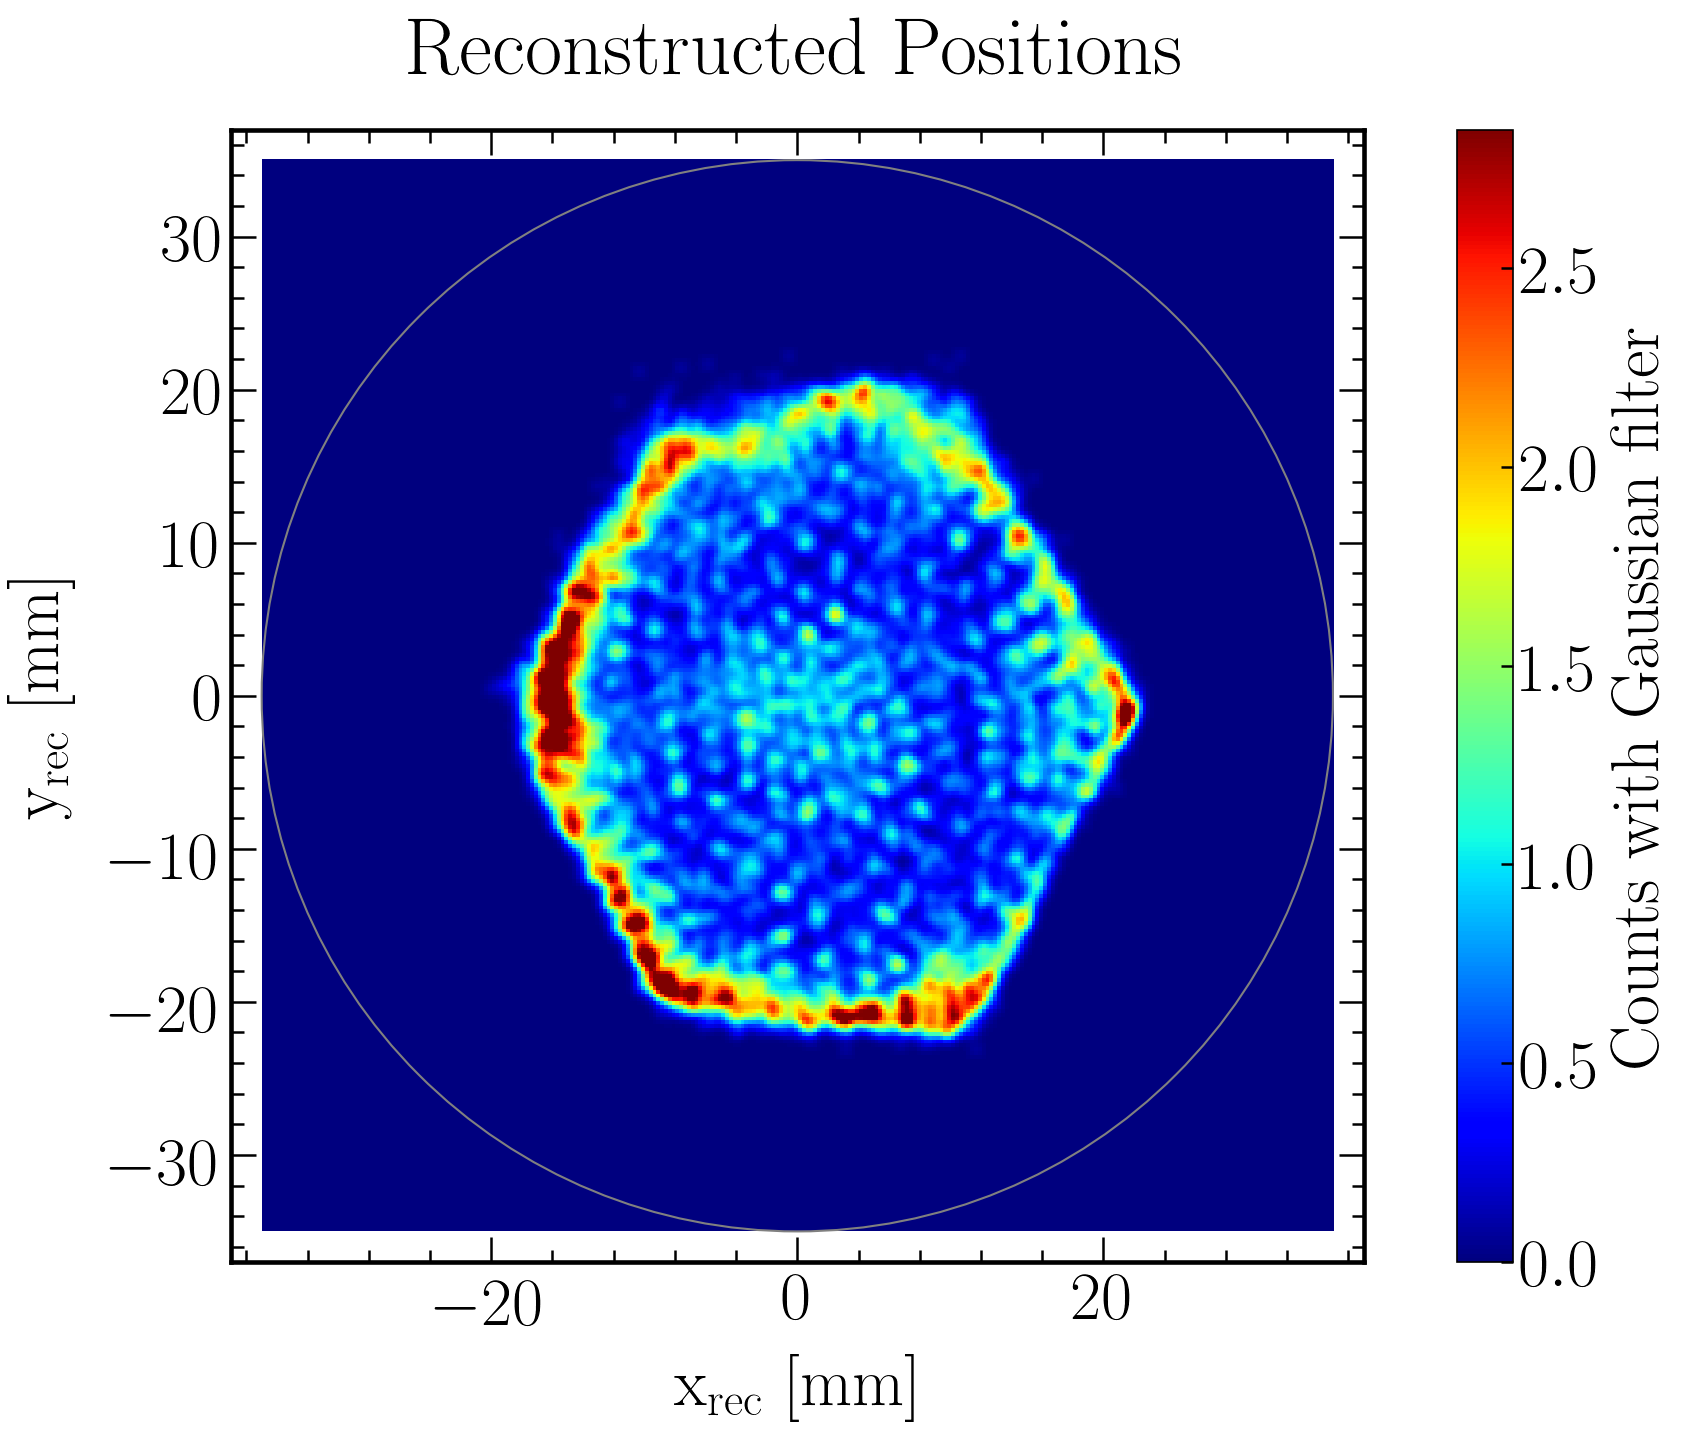

In [11]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
numberbins = 4*70
x = x_list
y = y_list

#plt.hist2d(x, y, bins=numberbins, range = [[-35, 35], [-35, 35]], cmap = 'jet')

s = 1.5

def myplot():
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=numberbins, range = [[-35, 35], [-35, 35]])
    heatmap = gaussian_filter(heatmap, sigma=s)
    
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

heatmap, extent = myplot()
plt.imshow(heatmap, extent=extent, origin='lower', cmap=cm.jet, interpolation='none')

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Counts with Gaussian filter', fontsize=label_size)

r_fiducial = 20 # fiducial radius in mm
cut_fiducial = np.hypot(x_list, y_list)<r_fiducial
n, xedges, yedges = np.histogram2d(x[cut_fiducial], y[cut_fiducial], bins=numberbins, range = [[-35, 35], [-35, 35]])
n = gaussian_filter(n, sigma=s)
#plt.clim(0.0, np.amax(n))
plt.clim(0.0, np.percentile(n[n>0], 99))

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid_cmap_filter.png", bbox_inches = "tight")

In [12]:
"""
Simple nearest neighbour method at pixel level. 
This method calculates for each pixel the inverse sum of the distances of the 
n closest points in the data. This method is at a high resolution pretty 
computationally expensive.
"""

def data_coord2view_coord(p, vlen, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * vlen
    return dv


def nearest_neighbours(xs, ys, reso, n_neighbours):
    im = np.zeros([reso, reso])
    extent = [-35, 35, -35, 35]

    xv = data_coord2view_coord(xs, reso, extent[0], extent[1])
    yv = data_coord2view_coord(ys, reso, extent[2], extent[3])
    for x in range(reso):
        for y in range(reso):
            xp = (xv - x)
            yp = (yv - y)

            d = np.sqrt(xp**2 + yp**2)

            im[y][x] = 1 / np.sum(d[np.argpartition(d.ravel(), n_neighbours)[:n_neighbours]])

    return im, extent

xs = x_list
ys = y_list
resolution = 250
neighbours = 16

im, extent = nearest_neighbours(xs, ys, resolution, neighbours)

In [13]:
posr = np.full((resolution, resolution), np.nan)

bns = np.linspace(extent[0], extent[1], num=resolution)
for j in range(0, resolution):
        for k in range(0, resolution):
            posr[j, k] = np.sqrt((bns[j])**2 + (bns[k])**2)
            
posr.shape

(250, 250)

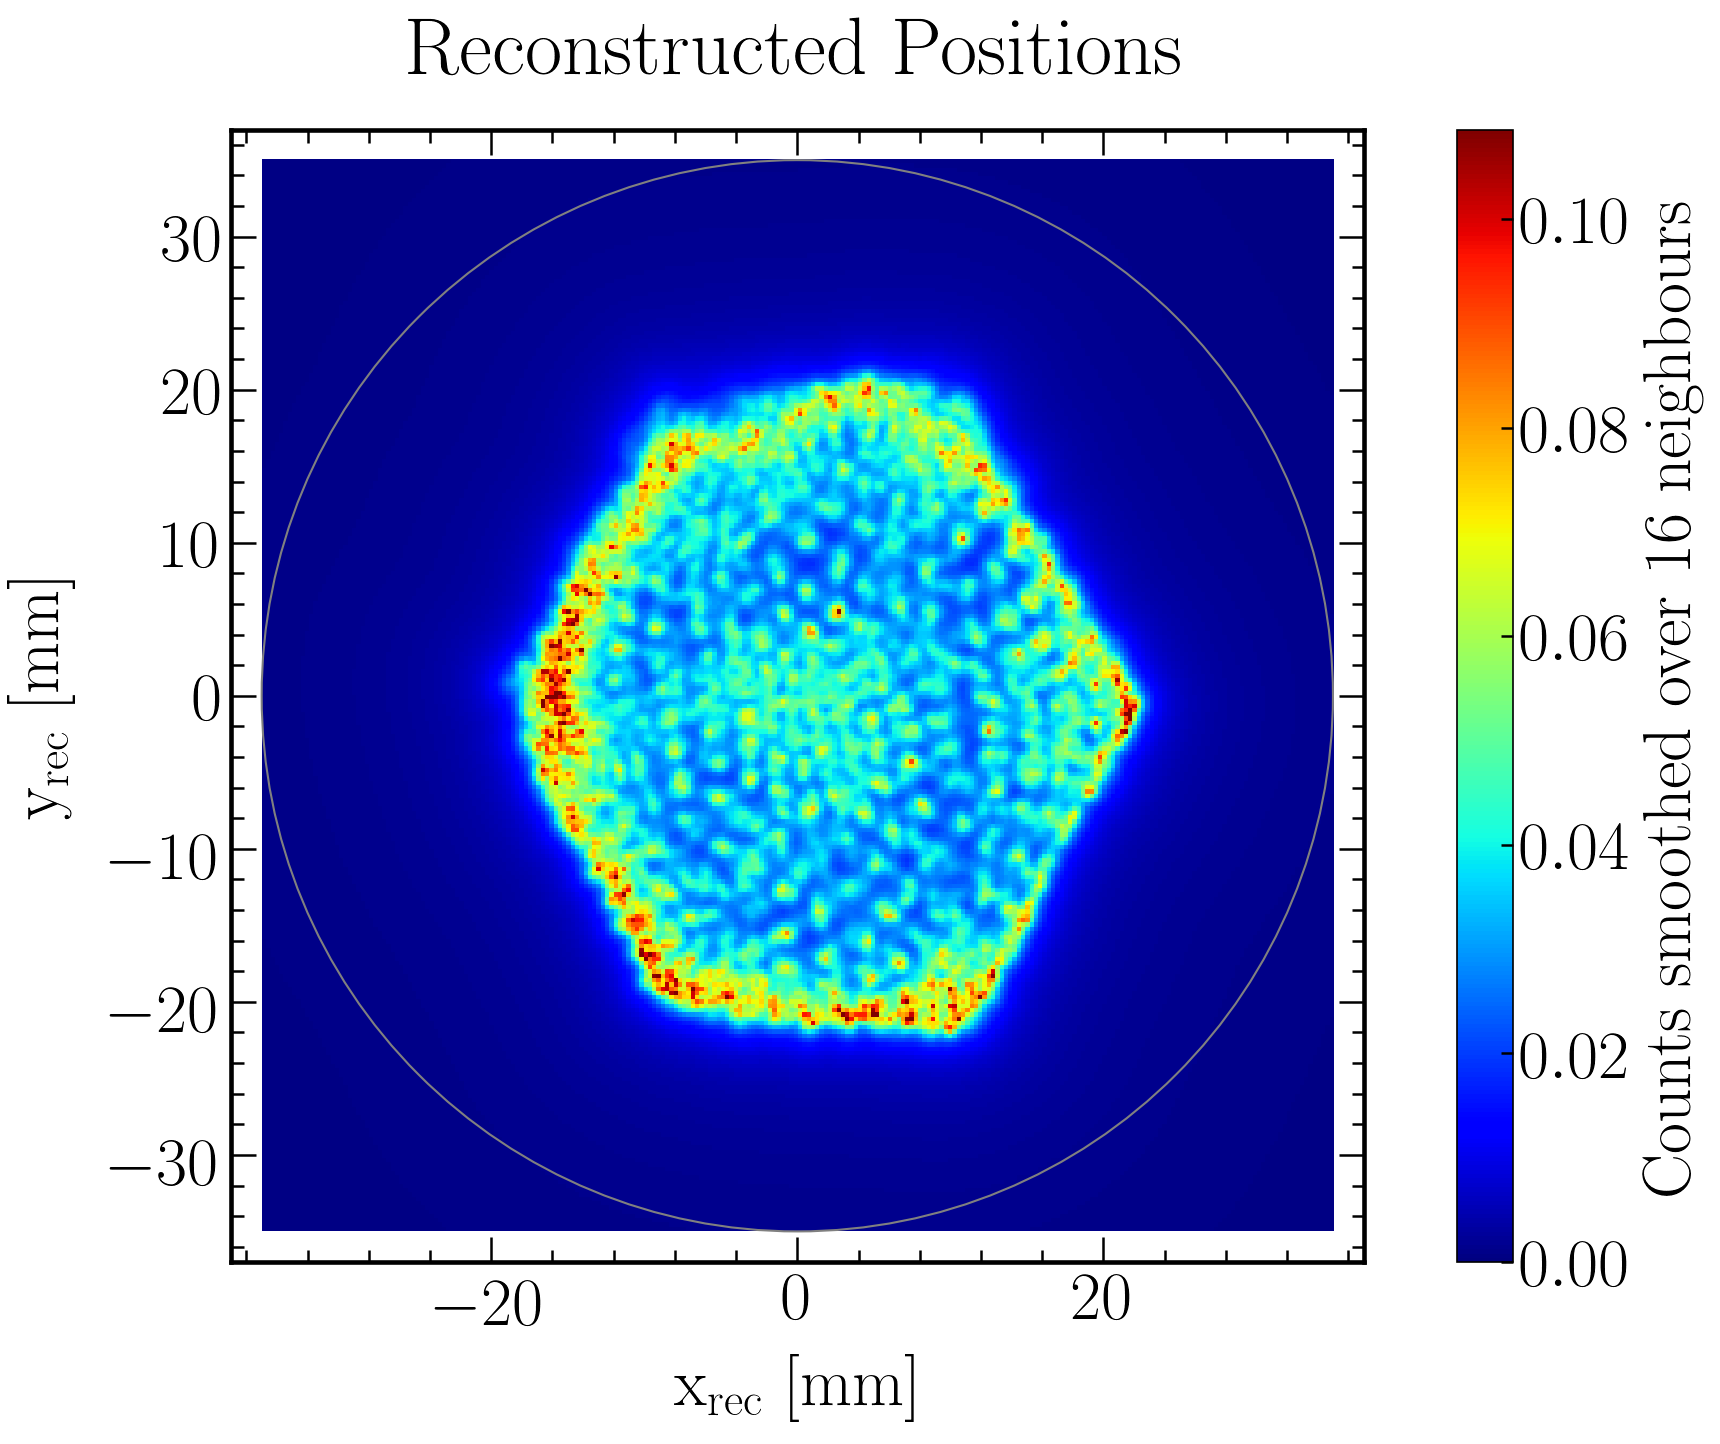

In [14]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot

plt.imshow(im, origin='lower', extent=extent, cmap=cm.jet)

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Counts smoothed over '+str(neighbours)+' neighbours', fontsize=label_size)

r_fiducial = 20 # fiducial radius in mm
cut_fiducial = posr<r_fiducial
n = im[cut_fiducial]
#plt.clim(0, np.amax(n))
plt.clim(0.0, np.percentile(n[n>0], 99.9))

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid_cmap_smoothed_"+str(neighbours)+"_neighbours.png", bbox_inches = "tight")

## Evaluation

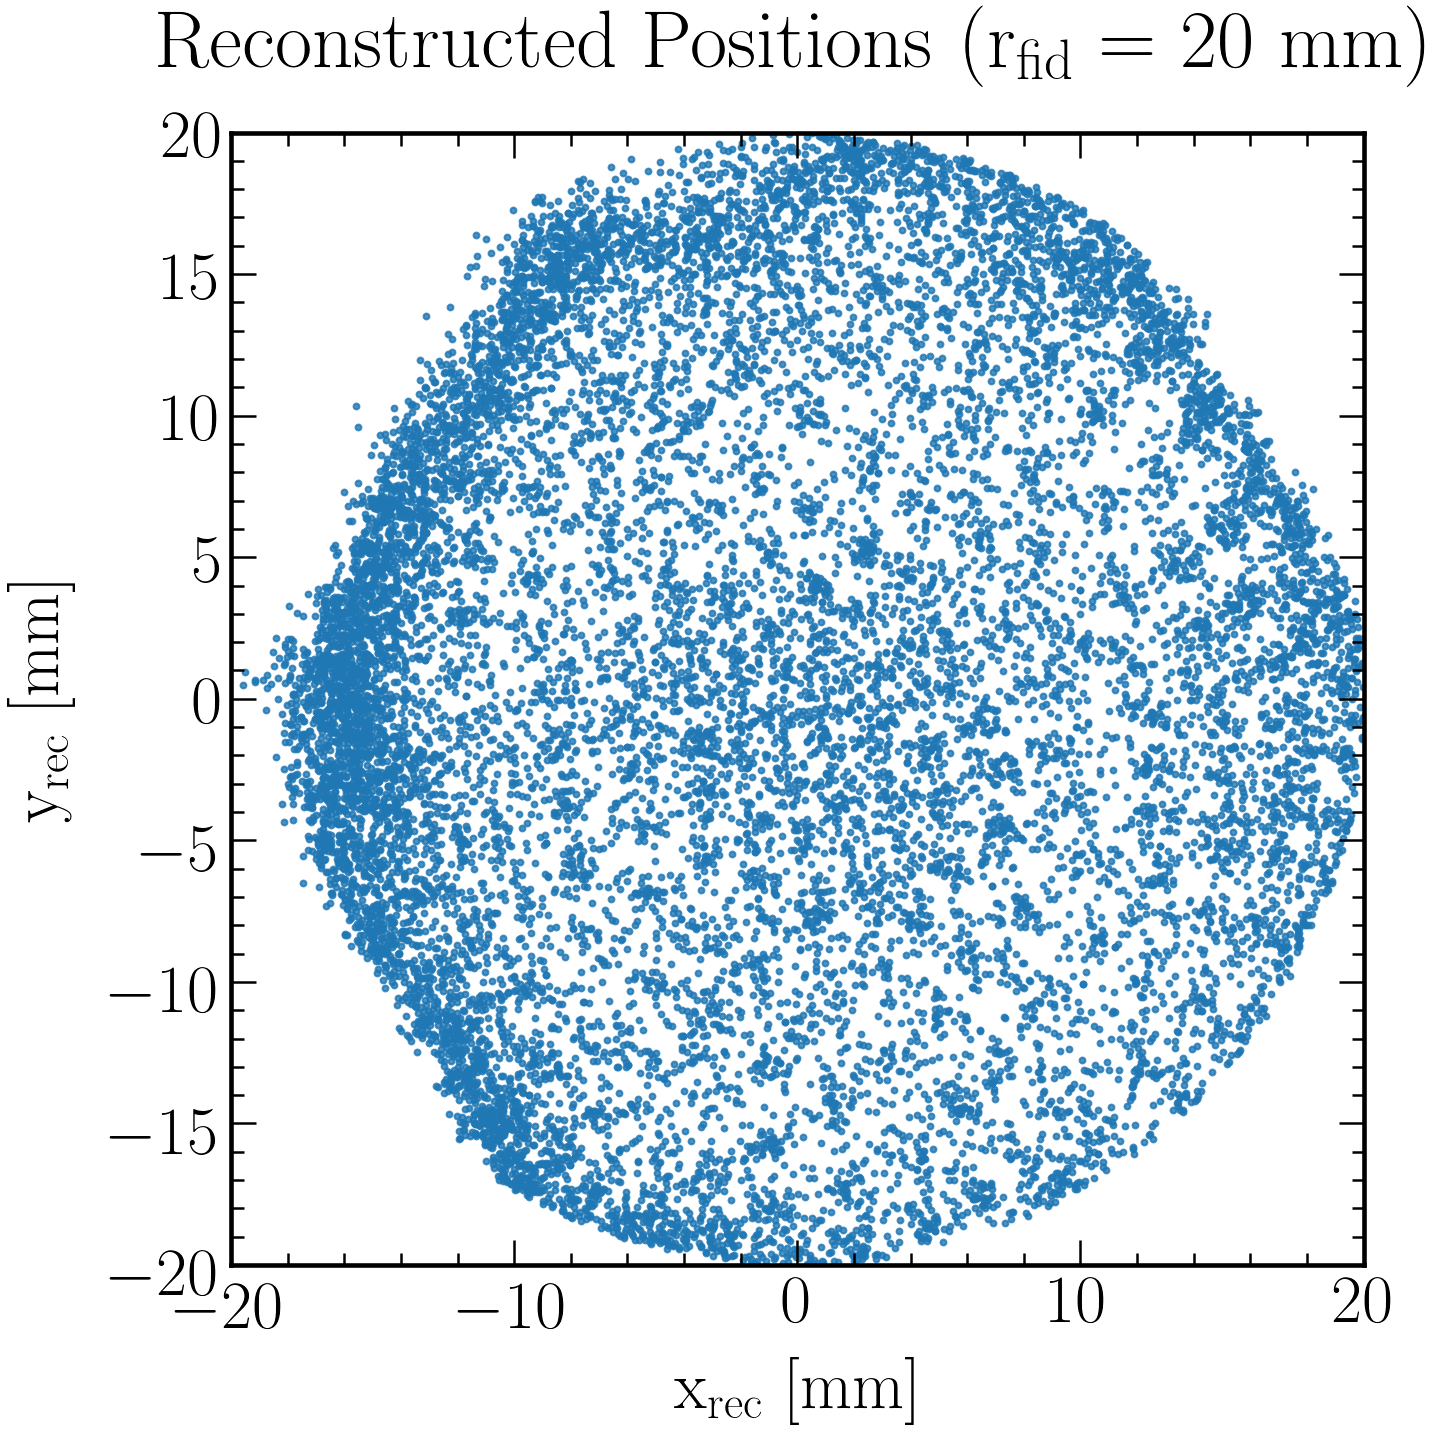

In [15]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
r_fiducial = 20 # fiducial radius in mm
cut_fiducial = np.hypot(x_list, y_list)<r_fiducial

plt.scatter(x_list[cut_fiducial],
            y_list[cut_fiducial],
            marker='.',
            #s=1,
            s = 10*(35/r_fiducial)**2,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-r_fiducial,r_fiducial)
plt.ylim(-r_fiducial,r_fiducial)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions (r$_\mathrm{fid}$ = '+str(r_fiducial)+' mm)', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid_fid_"+str(r_fiducial)+".png", bbox_inches = "tight")

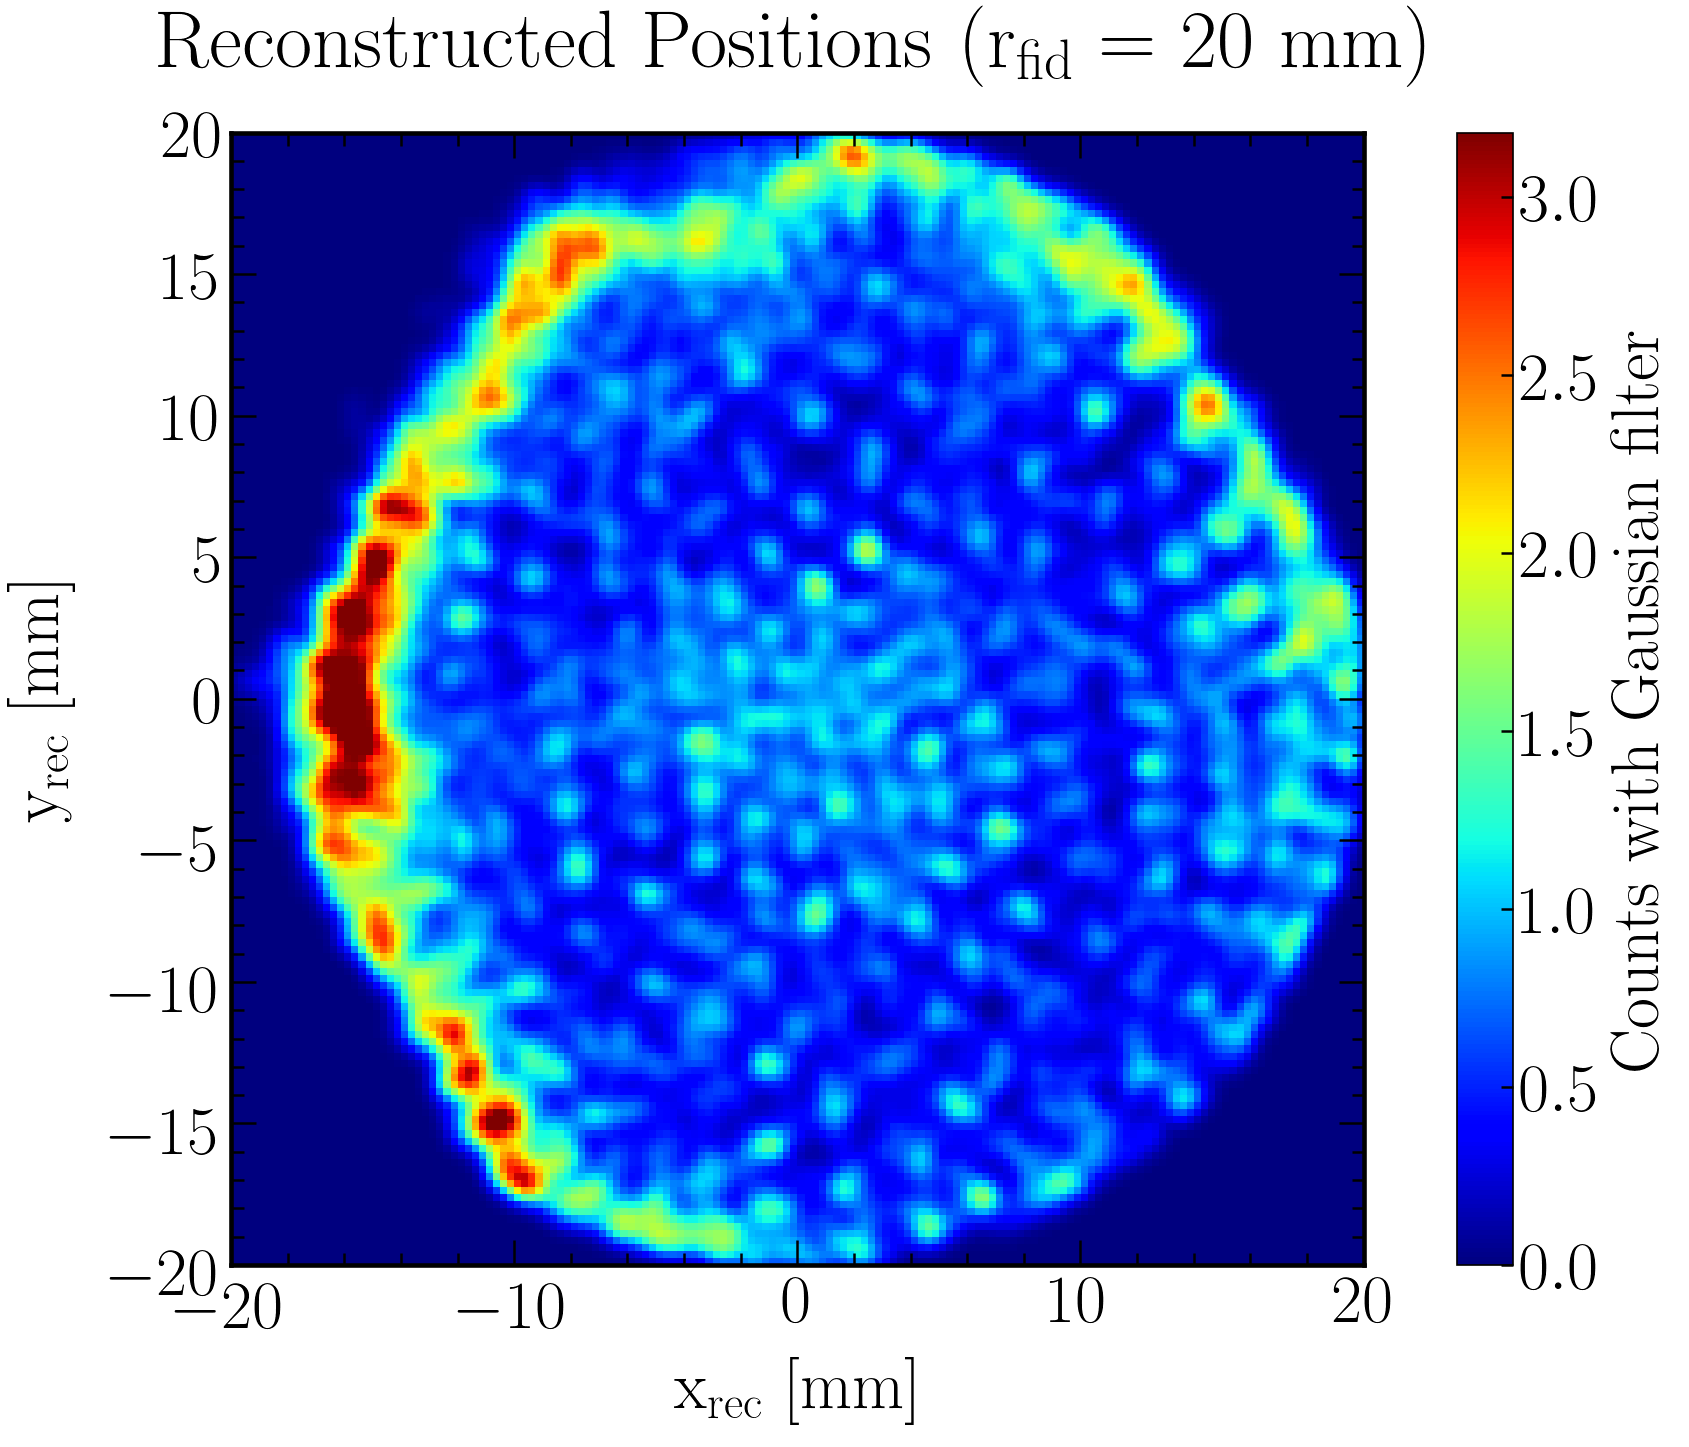

In [16]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
numberbins = 4*70

r_fiducial = 20 # fiducial radius in mm
cut_fiducial = np.hypot(x_list, y_list)<r_fiducial

x = x_list[cut_fiducial]
y = y_list[cut_fiducial]

#plt.hist2d(x, y, bins=numberbins, range = [[-35, 35], [-35, 35]], cmap = 'jet')

s = 1.5

def myplot():
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=numberbins, range = [[-35, 35], [-35, 35]])
    heatmap = gaussian_filter(heatmap, sigma=s)
    
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

heatmap, extent = myplot()
plt.imshow(heatmap, extent=extent, origin='lower', cmap=cm.jet, interpolation='none')

plt.xlim(-r_fiducial,r_fiducial)
plt.ylim(-r_fiducial,r_fiducial)

plt.xlabel('x$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions (r$_\mathrm{fid}$ = '+str(r_fiducial)+' mm)', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Counts with Gaussian filter', fontsize=label_size)

plt.clim(0.0, np.percentile(heatmap[heatmap>0], 99.5))

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_Centroid_fid_"+str(r_fiducial)+"_cmap_filter.png", bbox_inches = "tight")

pitch mesh = 3.00831 mm

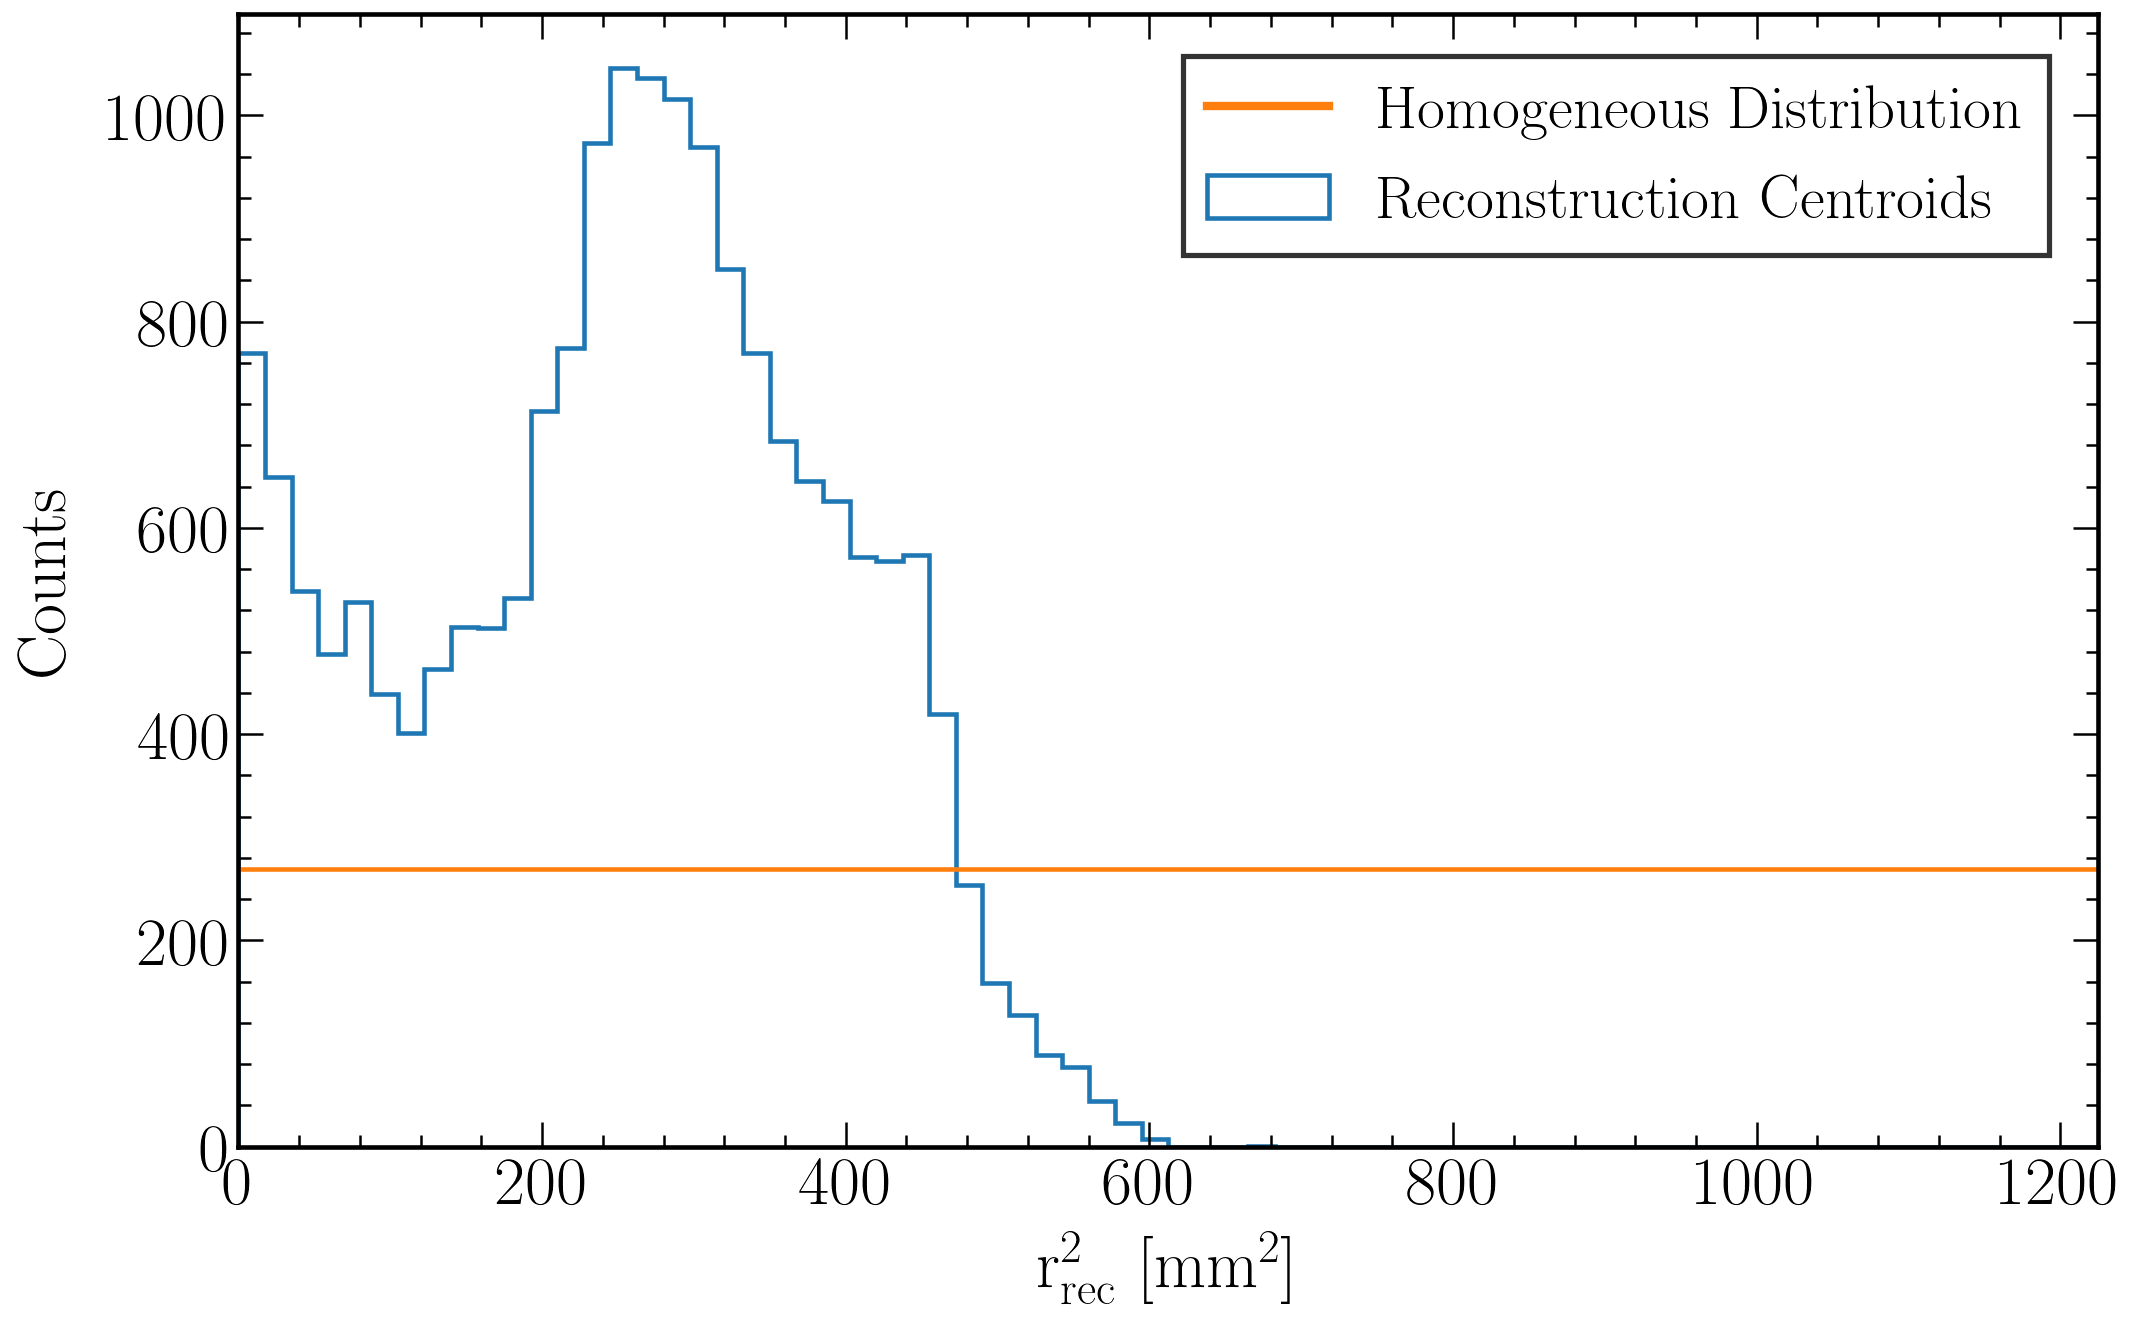

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(x_list, y_list)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroids')
plt.plot([0, 35**2], [x_list.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_r2spectrum.png")
plt.show()

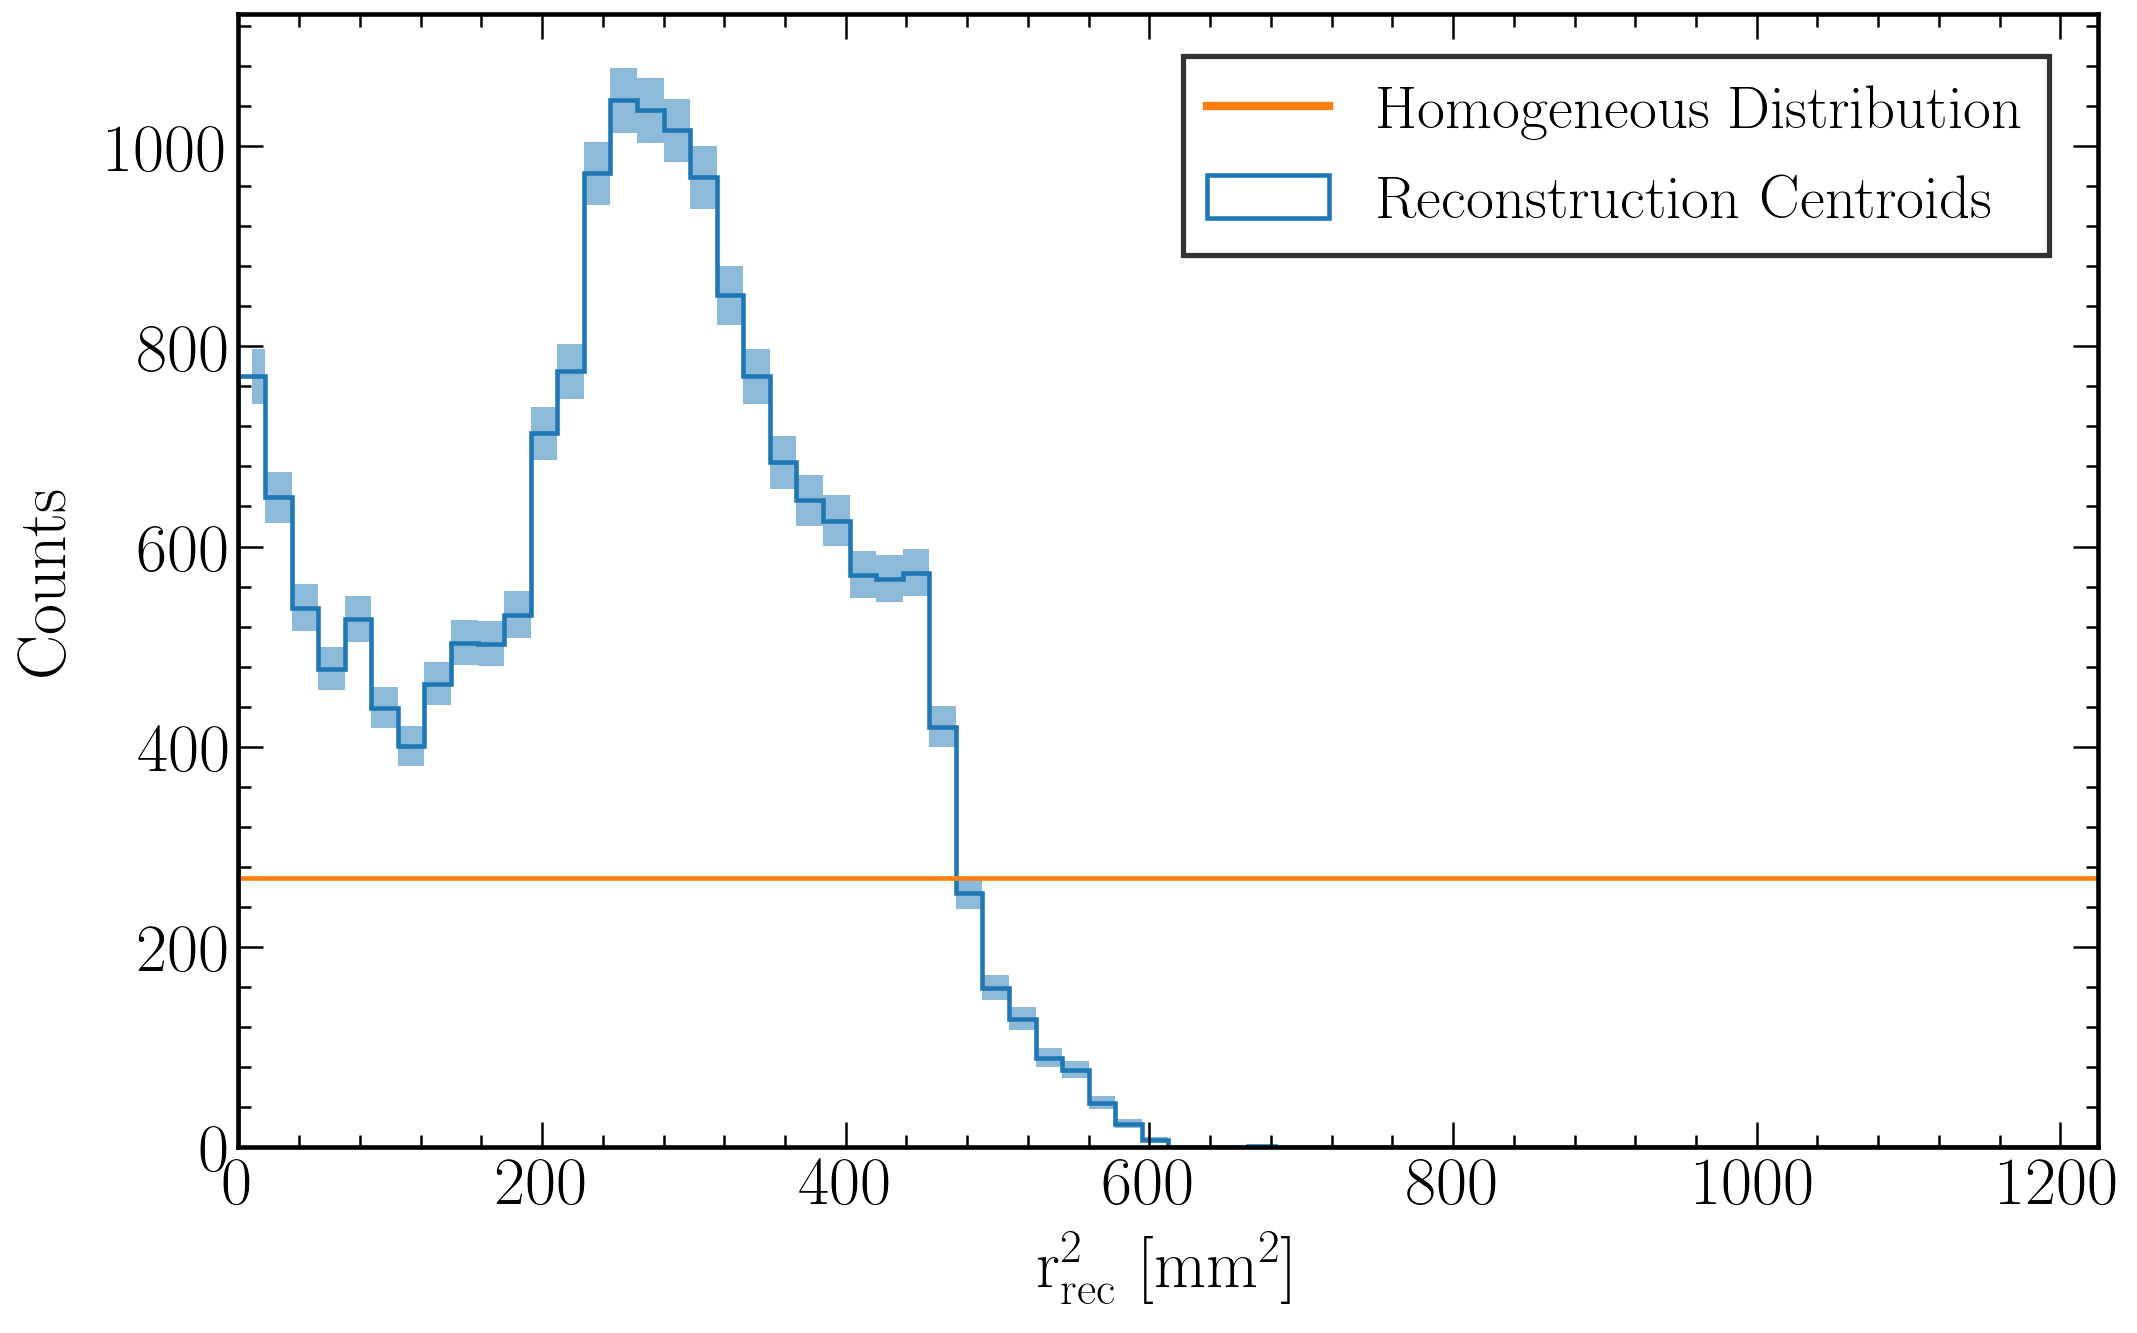

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.plot([0, 35**2], [x_list.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

n, bins, *patches = plt.hist(np.hypot(x_list, y_list)**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction Centroids')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_r2spectrum_witherror.png")
plt.show()

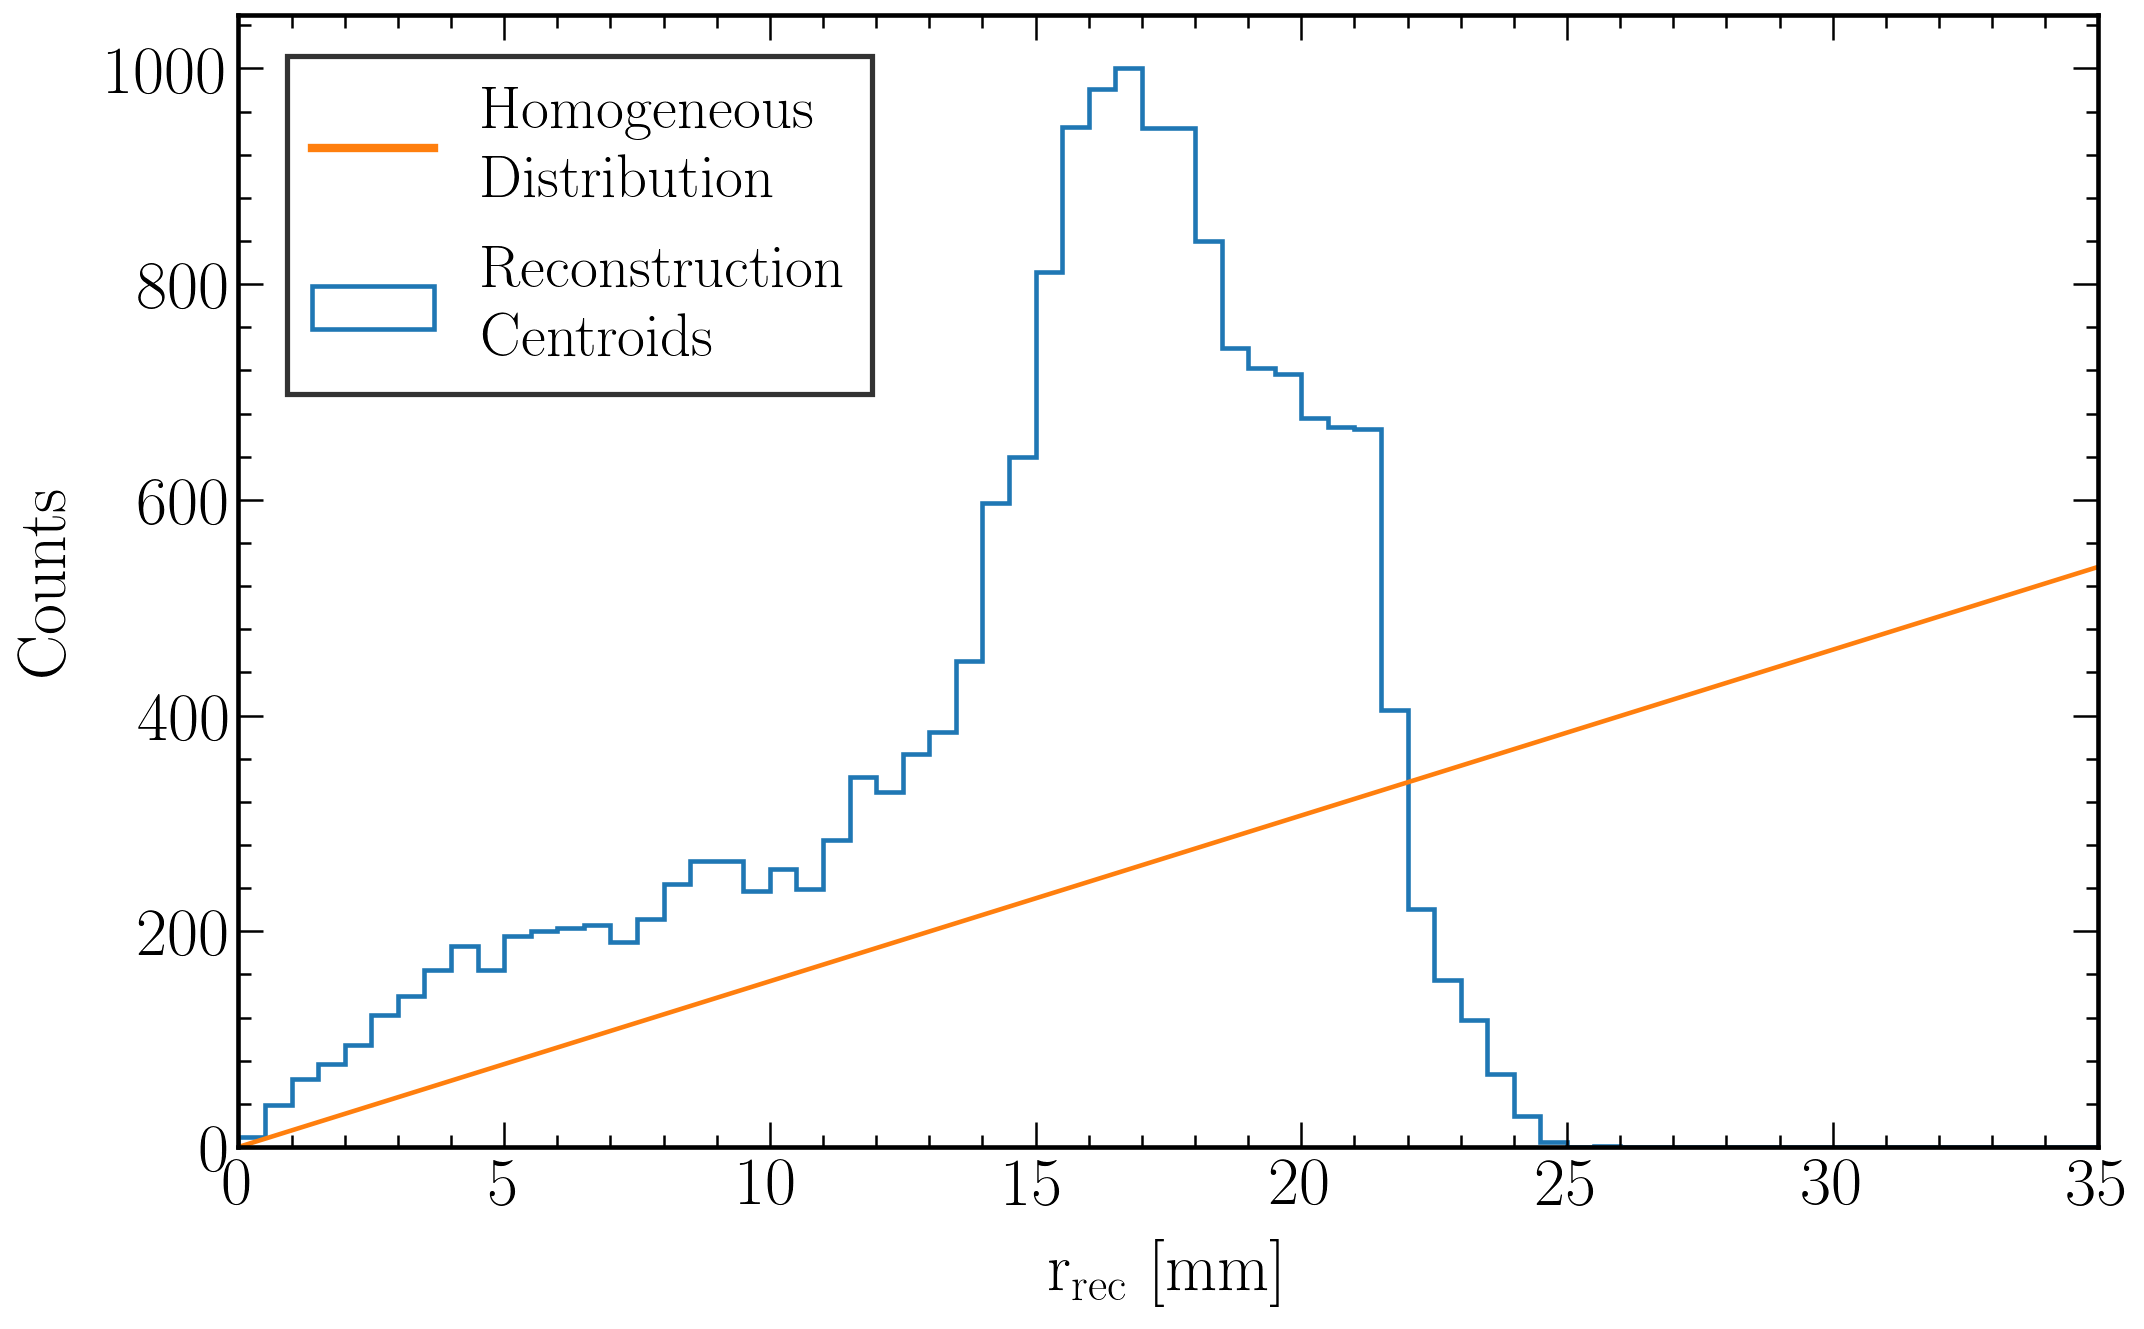

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(x_list, y_list), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction\nCentroids')
plt.plot([0, 35], [0, bns/35*x_list.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous\nDistribution')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_rspectrum.png")
plt.show()

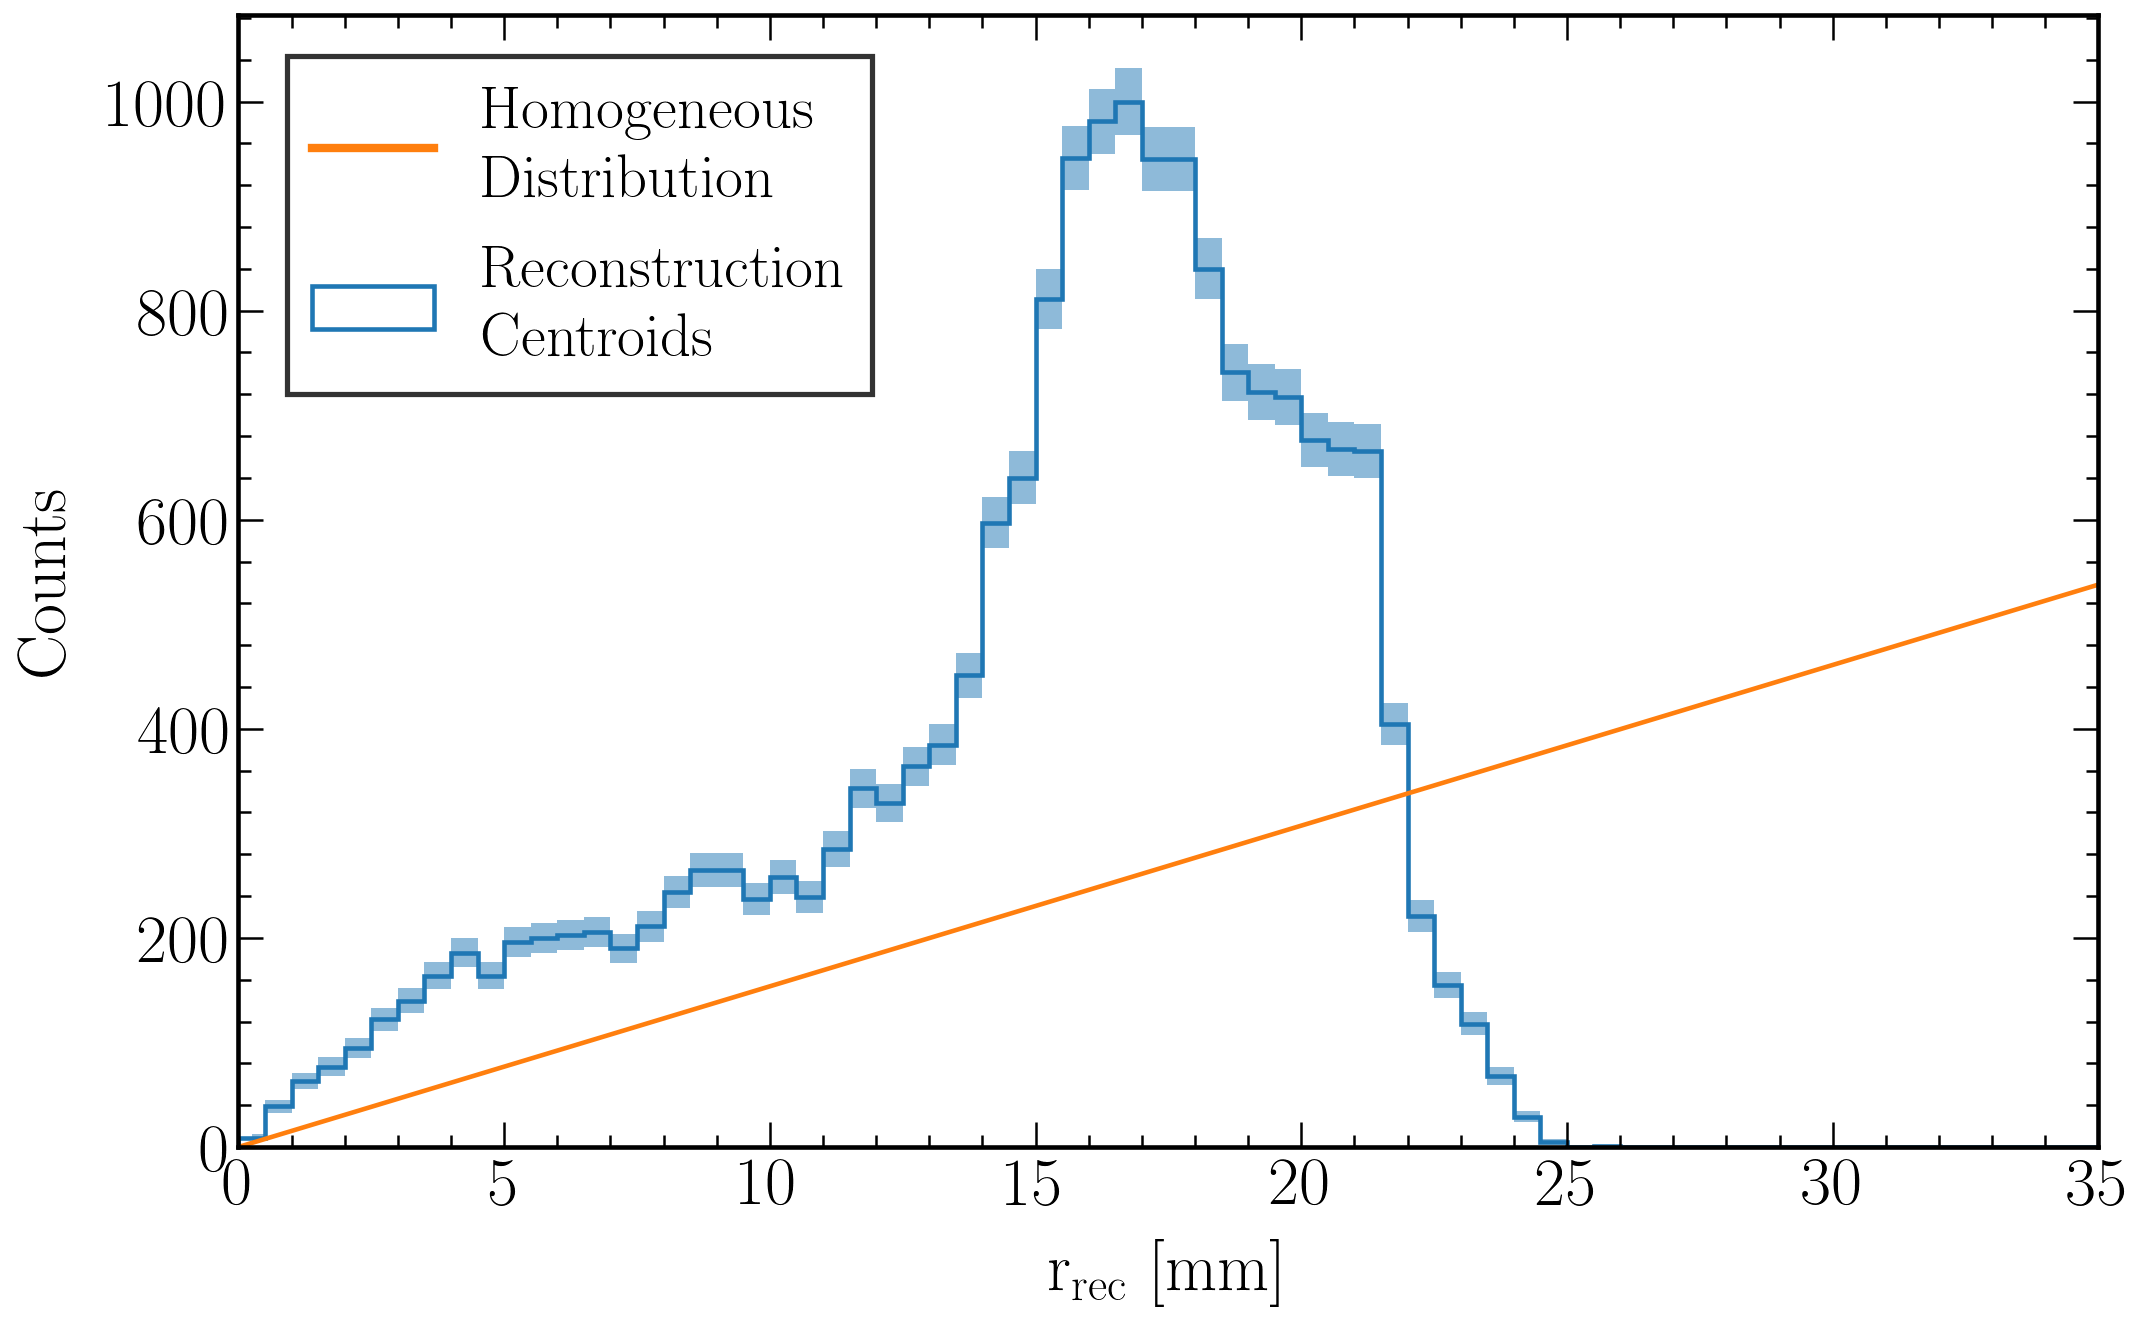

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.plot([0, 35], [0, bns/35*x_list.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous\nDistribution')

n, bins, *patches = plt.hist(np.hypot(x_list, y_list), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction\nCentroids')
bins_center = (bins[1:] + bins[:-1]) / 2
plt.fill_between(bins_center, n - np.sqrt(n), n + np.sqrt(n), facecolor='C0', 
                 alpha=0.5, step = 'mid')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_Centroid_rspectrum_witherror.png")
plt.show()